In [10]:
import torch
import torch.nn.functional as F
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import math

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
# show training images
def show_images(dataset, num_samples=20, cols=4):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img[0])

# data = torchvision.datasets.StanfordCars(root=".", download=True)
# show_images(data)

In [13]:
# Forward process - add noise to the images
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering a batch dimension
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Get nosied image at timestep t
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    # Mean + Variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

#define beta schedule
T = 200
betas = linear_beta_schedule(timesteps=T)

# Precompute alphas for closed form solution
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

In [14]:
# Test noising on our dataset
IMG_SIZE = 64
BATCH_SIZE = 256

def load_transformed_dataset():
    # Convert PIL image to tensor with some additional data augmentation.
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # scales between 0 and 1
        transforms.Lambda(lambda t: t * 2.0 - 1.0) # scale between -1 and 1
    ])
    train = torchvision.datasets.StanfordCars(root=".", download=True, transform=transform)
    test = torchvision.datasets.StanfordCars(root=".", download=True, transform=transform, split="test")
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    # Convert tensor image to pil image
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) /2), # converting this from normalized -1 to 1 values to 0 to 255 RGB values.
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])

    # Take first iamge of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)

In [15]:
# Simulate forward diffusion process
# for i, img in enumerate(dataloader):
#     img = img[0]

#     # Tensor with values 0, 20, 100 and 199
#     t = torch.tensor([0, 20, 100, 199]).to(img.device)

#     # Get noisy images at timesteps t
#     x_t, noise = forward_diffusion_sample(img, t)

#     # show
#     for i in range(len(t)):
#         # small plot
#         plt.figure(figsize=(5, 5))
#         plt.title(f"Image at timestep {t[i]}")
#         show_tensor_image(x_t[i])

#     break

In [16]:
# Unet - simplified. TODO go deeper into understanding what is happening in the block and Unet forward function
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        if up:
            self.conv1 = nn.Conv2d(2*in_channels, out_channels, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(3, stride=2)
        self.bnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x, t, ):
        h = self.bnorm(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2] # extend last 2 dimensions to get the shapes right.
        h = h + time_emb
        h = self.bnorm(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionalEmbedding(nn.Module):
    """Encode positions with a sinusoid.
    
    I don't entirely understand how this is calculated but it's encoding positions.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        return embeddings
        

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )

        # Initial convolution
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1) # kernel size = 3 to maintain image size

        # # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) for i in range(len(down_channels) - 1)])

        # # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])

        # Output
        self.output = nn.Conv2d(up_channels[-1], 3, out_dim) # maintain same image size as input.
    
    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)

        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1) # adding residual connection
            x = up(x, t)
        return self.output(x)


In [17]:
# Loss function - simple 
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device="cuda")
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [18]:
# Train
train = False # Do we train?
checkpoint_path = "output/model_214.pt"

# Training loop for one epoch on diffusion model on cuda
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleUnet().to(device)

# Load checkpoint path
if not train:
    model.load_state_dict(torch.load(checkpoint_path))
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(50):
        for i, (x_0, _) in tqdm(enumerate(dataloader), total=len(dataloader)):
            x_0 = x_0.to(device)
            t = torch.randint(0, T, (BATCH_SIZE, )).to(device)
            loss = get_loss(model, x_0, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"Epoch {epoch}, iteration {i}, loss {loss.item()}")

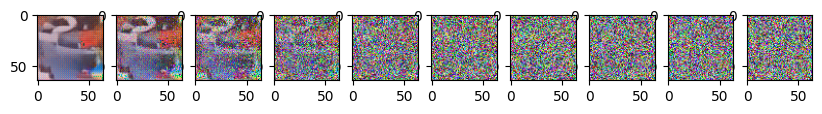

In [24]:
# Sample new images
@torch.no_grad()
def sample_timestep(x, t):
    """Calls the model to predict the noise in the image and returns the denoised image. Applies noise to this image, if we are not in the last step yet."""
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        # Add noise
        noise = torch.randn_like(model_mean)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn(1, 3, img_size, img_size, device=device)
    plt.figure(figsize=(10, 10))
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i//stepsize + 1)
            show_tensor_image(img.detach().cpu())
    plt.show()

# Sample trained images
sample_plot_image()